In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
from tqdm.notebook import tqdm
from data_processing.GameFeaturesGenerator import GameFeaturesGenerator
from data_processing.TournamentDataProcessor import TournamentDataProcessor
from data_processing.LeaguesDataProcessor import LeaguesDataProcessor
from data_processing.utils.download_functions import *
os.chdir('esports-data')
os.listdir()

['2021_raw_game_data',
 'games',
 'leagues.json',
 'mapping_data.json',
 'players.json',
 'teams.json',
 'tournaments.json']

In [2]:
# Read in teams data
with open("teams.json", "r") as json_file:
   teams_data = json.load(json_file)

team_df = []
for team in teams_data:
    team_df.append({'team_id': team['team_id'], 'team_name': team['name']})
    
team_df = pd.DataFrame(team_df)

In [3]:
# Get all file names from '2021_raw_game_data'
file_names = os.listdir('2021_raw_game_data')

# Get the unique tournament names by stripping out '_game_rows.csv' and '_tournament_rows.csv'
unique_tournament_names = [file_name.split('_game_rows.csv')[0] for file_name in file_names]
unique_tournament_names = [x.replace('_tournament_rows.csv', '') for x in unique_tournament_names]
unique_tournament_names = list(set(unique_tournament_names))

In [4]:
 # ['League_TFT Rising Legends', 'League_MSI', 'League_Worlds', 'League_All-Star Event'] 

In [66]:
# Aggregate all the game rows into one dataframe, start with an empty dataframe and append onto it to save memory
tournament_rows = pd.DataFrame()
for tournament_name in tqdm(unique_tournament_names):
    df_tmp = pd.read_csv('2021_raw_game_data/' + tournament_name + '_tournament_rows.csv')
    # Add a column to indicate the tournament name
    df_tmp['tournament_name'] = tournament_name
    tournament_rows = pd.concat([tournament_rows, df_tmp])
tournament_rows.shape

game_rows = pd.DataFrame()
for tournament_name in tqdm(unique_tournament_names):
    df_tmp = pd.read_csv('2021_raw_game_data/' + tournament_name + '_game_rows.csv', index_col=0)
    # Add a column to indicate the tournament name
    df_tmp['tournament_name'] = tournament_name
    game_rows = pd.concat([game_rows, df_tmp])
game_rows.shape

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

(9574, 1243)

In [67]:
non_game_features = ['platformGameId', 'esportsGameId', 'team_id', 'start_time', 'tournament_name']
league_indicators_to_drop = ['League_TFT Rising Legends', 'League_All-Star Event', 'League_MSI', 'League_Worlds']
league_indicators = [x for x in game_rows.columns if 'League_' in x]
league_indicators = [x for x in league_indicators if x not in league_indicators_to_drop]
game_rows = game_rows.drop(columns=league_indicators_to_drop, axis=1)


# Keep this if we want to analyze specific tournaments (e.g. MSI and Worlds) or if we want to upweight/downweight certain tournaments 
# game_rows = game_rows.drop(columns=['tournament_name'], axis=1)  

game_features = [x for x in game_rows.columns if x not in non_game_features + league_indicators]
all_team_ids = np.unique(game_rows['team_id'])
print(len(all_team_ids))

240


In [68]:
"""
1. Sort the game_rows by team_id and start_time 
2. Create features for each team by averaging stats of the last 5 games that they played (or the most recent statistics if possible, with a "num_prev_games) column
    This yields a row of data where the features are the average of the last 5 games that the team played BEFORE the game of ['platformGameId', 'esportsGameId', 'team_id', 'start_time']
    We also need to drop the first row where we don't have any data to average over
3. Mark the last row of each team's data as the last game
    This is so that we can use this to predict the next game
3. Later join to the reg_season_games data for training the model 
4. Use the trained model to predict on the playoff_games data for testing 
"""

processed_game_data = []
for team in tqdm(all_team_ids):
    team_data = game_rows[game_rows['team_id']==team]
    team_data = team_data.sort_values(by=['start_time'])
    team_data['num_prev_games'] = np.arange(len(team_data))
    # First lag by 1 game so that the current game is not included in the average. Then take the mean as the trailing average 
    team_data_features = team_data[game_features].shift(1).rolling(window=20, min_periods=1).mean()
    league_features = team_data[league_indicators].rolling(window=9999, min_periods=1).max()
    team_data[game_features] = team_data_features
    team_data[league_indicators] = league_features
    # Drop rows where num_prev_games == 0 as this indicates that it's the team's first game 
    team_data = team_data[team_data['num_prev_games']!=0]
    # Add one more column to indicate if the row is the last of the team's games
    # last_game_indicator_col = pd.DataFrame({'last_game_ind': team_data['num_prev_games']==team_data['num_prev_games'].max()})
    # team_data = pd.concat([team_data, last_game_indicator_col], axis=1)
    processed_game_data.append(team_data)

processed_game_data = pd.concat(processed_game_data)
print(len(processed_game_data))

# inference_game_data = processed_game_data[processed_game_data['last_game_ind']==True]

  0%|          | 0/240 [00:00<?, ?it/s]

9334


In [69]:
# Maintain a manual dictionary of team_id to league_indicator
# Loop through this and mark the league_indicator for each team_id as =1 for the rows where the team_id is present
league_indicator_dict = {
    '98767991892579754': 'League_LPL',  # RNG
    '104367068120825486': 'League_PCS',  # PSG Talon
    '98767991882270868': 'League_LPL',  # EDG
    '99566404850008779': 'League_LPL',  # LNG
    '99566404855553726': 'League_LPL',  # FPX
}
for team_id, league_indicator in league_indicator_dict.items():
    processed_game_data.loc[processed_game_data['team_id']==team_id, league_indicator] = 1

In [70]:
def rename_features(df, features, prefix):
    return df.rename(columns=dict(zip(features, [f'{prefix}_{x}' for x in features])))

tournament_rows = TournamentDataProcessor.append_flipped_team_and_outcomes(tournament_rows)
tournament_rows.shape

(9980, 8)

In [71]:
training_data = tournament_rows.merge(rename_features(processed_game_data.drop(['platformGameId', 'start_time'], axis=1), game_features + league_indicators, "team_1"), 
                                    how='left', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])
training_data = training_data.merge(rename_features(processed_game_data.drop(['platformGameId', 'start_time'], axis=1), game_features + league_indicators, "team_2"), 
                                    how='left', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

# drop the games where the outcome is NaN, those games are when one team has not had any games yet
training_data.dropna(subset=['team_1_outcome', 'team_2_outcome'], inplace=True)

# At this point all remaining nan values occur because the team has not reached a certain status yet (e.g. no first kills in any games up to that point)
# Fill these with -1
training_data.fillna(-1, inplace=True)

# Drop the columns that were used for joining (have '_to_drop' suffix). 
training_data.drop([x for x in training_data.columns if '_to_drop' in x], axis=1, inplace=True)

In [72]:
training_data.iloc[0]

match_id                                        106748850930223378
esportsGameId                                   106748850930223379
league                                                EMEA Masters
team_id_1                                       105532791598779236
outcome_1                                                        0
                                            ...                   
team_2_League_SuperLiga                                        0.0
team_2_League_TCL                                              0.0
team_2_League_Ultraliga                                        0.0
team_2_League_VCS                                              0.0
tournament_name            european_masters_summer_2021_main_event
Name: 0, Length: 2476, dtype: object

In [108]:
# Do XGB on the training data
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

target_col = 'outcome_1'
## At this point could assign row weights based on 'tournament_name' column to upweight/downweight certain tournaments
X = training_data.drop(['match_id', 'esportsGameId', 'league', 'team_id_1', 'outcome_1', 'team_id_2', 'outcome_2'], axis=1)
y = training_data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Get all indices where X_train['tournment_name'] contains ['worlds', 'msi'] 
international_ix_train = X_train['tournament_name'].str.contains('worlds|msi')
international_ix_test = X_test['tournament_name'].str.contains('worlds|msi')

# Create a weight vector where the international games are weighted 2x
weights_train = np.ones(len(X_train))
weights_train[international_ix_train] = 4

X_train = X_train.drop('tournament_name', axis=1)
X_test = X_test.drop('tournament_name', axis=1)


dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [119]:
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=15,
    evals=[(dtest, "Test")],
    early_stopping_rounds=50)

[0]	Test-logloss:0.68776
[1]	Test-logloss:0.68451
[2]	Test-logloss:0.68317
[3]	Test-logloss:0.68104
[4]	Test-logloss:0.67923
[5]	Test-logloss:0.67598
[6]	Test-logloss:0.67336
[7]	Test-logloss:0.67253
[8]	Test-logloss:0.67246
[9]	Test-logloss:0.67062
[10]	Test-logloss:0.67001
[11]	Test-logloss:0.66982
[12]	Test-logloss:0.66996
[13]	Test-logloss:0.66966
[14]	Test-logloss:0.67078


In [120]:
yhat_train_model = np.round(model.predict(dtrain))
yhat_train_base = X_train['team_1_outcome'] >= X_train['team_2_outcome']

yhat_test_model = np.round(model.predict(dtest))
yhat_test_base = X_test['team_1_outcome'] >= X_test['team_2_outcome']

In [121]:
# TRAINING DATA
print("TRAINING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_train, yhat_train_model)}")
print(f"Accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_model[international_ix_train])}")
print(f"Accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_model[~international_ix_train])}")

print()

# Evaluate the accuracy for the baseline
print(f"Baseline accuracy overall: {accuracy_score(y_train, yhat_train_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_base[international_ix_train])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_base[~international_ix_train])}")

# TESTING DATA 
print("\n TESTING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_test, yhat_test_model)}")
print(f"Accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_model[international_ix_test])}")
print(f"Accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_model[~international_ix_test])}")

print()

# Evaluate the accuracy for the baseline 
print(f"Baseline accuracy overall: {accuracy_score(y_test, yhat_test_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_base[international_ix_test])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_base[~international_ix_test])}")

TRAINING DATA
Accuracy overall: 0.9844516206195432
Accuracy international: 1.0
Accuracy domestic: 0.9837986041874377

Baseline accuracy overall: 0.5646453773472073
Baseline accuracy international: 0.5964391691394659
Baseline accuracy domestic: 0.5633100697906281

 TESTING DATA
Accuracy overall: 0.5920344456404736
Accuracy international: 0.7021276595744681
Accuracy domestic: 0.5861678004535147

Baseline accuracy overall: 0.5575888051668461
Baseline accuracy international: 0.6808510638297872
Baseline accuracy domestic: 0.5510204081632653


<Axes: >

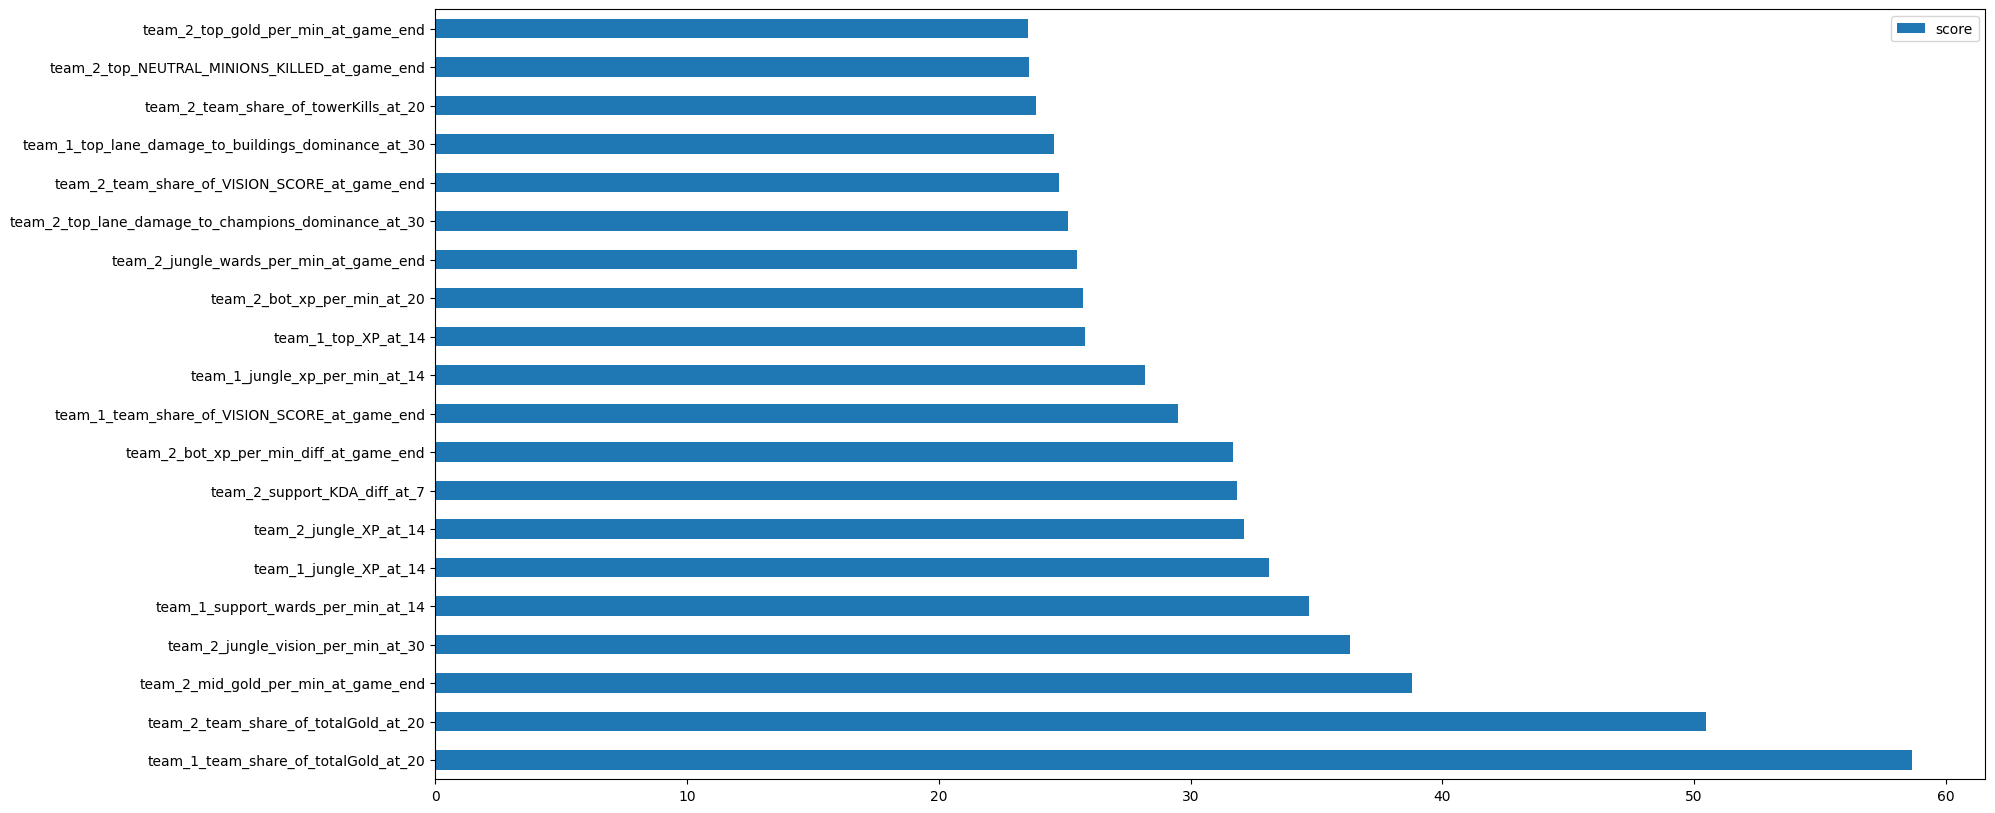

In [112]:
# Check the feature importance of the model
feature_importance = model.get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [59]:
# LPL has issues in Worlds and MSI because they don't show up in the data until 2023. We have to manually detect and relabel them.
# Do this by filtering to rows where tournament name is MSI or Worlds, and get teams where the sum of the league indicators is 0 (i.e. they haven't played anywhere prior)
LPL_teams = []

league_colnames = [x for x in processed_game_data.columns if 'League' in x]
msi_rows = processed_game_data[processed_game_data['tournament_name']=='worlds_2021'][non_game_features + league_indicators]
msi_rows['team_id'] = msi_rows['team_id'].astype('str')
# join msi rows with the team_name
msi_rows = msi_rows.merge(team_df, on='team_id', how='left')
msi_rows[msi_rows[league_indicators].sum(axis=1) == 1][['team_id', 'team_name']]

,team_id,team_name
38,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
39,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
40,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
41,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
42,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
43,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
44,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
45,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
46,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
47,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
